# 1

Using plaidml.keras.backend backend.
INFO:plaidml:Opening device "opencl_amd_gfx902.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                26600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 26,626
Trainable params: 26,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
648/648 [==============================] - 5s 8ms/step - loss: 0.0626 - mean_squared_error: 0.0626
Epoch 2/300
648/648 [==============================] - 0s 146us/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 3/300
648/648 [==============================] - 0s 143us/step - loss: 0.0142 - mean_squared_error: 0.0142
Epoch 4/300
648/648 [==============================] - 0s 136us/s

648/648 [==============================] - 0s 176us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 67/300
648/648 [==============================] - 0s 175us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 68/300
648/648 [==============================] - 0s 171us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 69/300
648/648 [==============================] - 0s 178us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 70/300
648/648 [==============================] - 0s 175us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 71/300
648/648 [==============================] - 0s 170us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 72/300
648/648 [==============================] - 0s 184us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 73/300
648/648 [==============================] - 0s 176us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 74/300
648/648 [==============================] - 0s 167us/step - loss: 0.0012 - mean_squared_e

Epoch 135/300
648/648 [==============================] - 0s 209us/step - loss: 9.4986e-04 - mean_squared_error: 9.4986e-04
Epoch 136/300
648/648 [==============================] - 0s 166us/step - loss: 9.8565e-04 - mean_squared_error: 9.8565e-04
Epoch 137/300
648/648 [==============================] - 0s 169us/step - loss: 8.6690e-04 - mean_squared_error: 8.6690e-04
Epoch 138/300
648/648 [==============================] - 0s 189us/step - loss: 7.9222e-04 - mean_squared_error: 7.9222e-04
Epoch 139/300
648/648 [==============================] - 0s 188us/step - loss: 8.5272e-04 - mean_squared_error: 8.5272e-04
Epoch 140/300
648/648 [==============================] - 0s 170us/step - loss: 8.5557e-04 - mean_squared_error: 8.5557e-04
Epoch 141/300
648/648 [==============================] - 0s 186us/step - loss: 8.4960e-04 - mean_squared_error: 8.4960e-04
Epoch 142/300
648/648 [==============================] - 0s 189us/step - loss: 8.0953e-04 - mean_squared_error: 8.0953e-04
Epoch 143/300
64

648/648 [==============================] - 0s 173us/step - loss: 7.7555e-04 - mean_squared_error: 7.7555e-04
Epoch 202/300
648/648 [==============================] - 0s 177us/step - loss: 7.3019e-04 - mean_squared_error: 7.3019e-04
Epoch 203/300
648/648 [==============================] - 0s 180us/step - loss: 6.9079e-04 - mean_squared_error: 6.9079e-04
Epoch 204/300
648/648 [==============================] - 0s 177us/step - loss: 6.8488e-04 - mean_squared_error: 6.8488e-04
Epoch 205/300
648/648 [==============================] - 0s 173us/step - loss: 7.4384e-04 - mean_squared_error: 7.4384e-04
Epoch 206/300
648/648 [==============================] - 0s 172us/step - loss: 7.6528e-04 - mean_squared_error: 7.6528e-04
Epoch 207/300
648/648 [==============================] - 0s 170us/step - loss: 6.9940e-04 - mean_squared_error: 6.9940e-04
Epoch 208/300
648/648 [==============================] - 0s 174us/step - loss: 7.0358e-04 - mean_squared_error: 7.0358e-04
Epoch 209/300
648/648 [=======

648/648 [==============================] - 0s 170us/step - loss: 7.9950e-04 - mean_squared_error: 7.9950e-04
Epoch 268/300
648/648 [==============================] - 0s 174us/step - loss: 7.6779e-04 - mean_squared_error: 7.6779e-04
Epoch 269/300
648/648 [==============================] - 0s 171us/step - loss: 6.5018e-04 - mean_squared_error: 6.5018e-04
Epoch 270/300
648/648 [==============================] - 0s 172us/step - loss: 6.8189e-04 - mean_squared_error: 6.8189e-04
Epoch 271/300
648/648 [==============================] - 0s 171us/step - loss: 6.3376e-04 - mean_squared_error: 6.3376e-04
Epoch 272/300
648/648 [==============================] - 0s 169us/step - loss: 6.8000e-04 - mean_squared_error: 6.8000e-04
Epoch 273/300
648/648 [==============================] - 0s 171us/step - loss: 5.9370e-04 - mean_squared_error: 5.9370e-04
Epoch 274/300
648/648 [==============================] - 0s 174us/step - loss: 5.9316e-04 - mean_squared_error: 5.9316e-04
Epoch 275/300
648/648 [=======

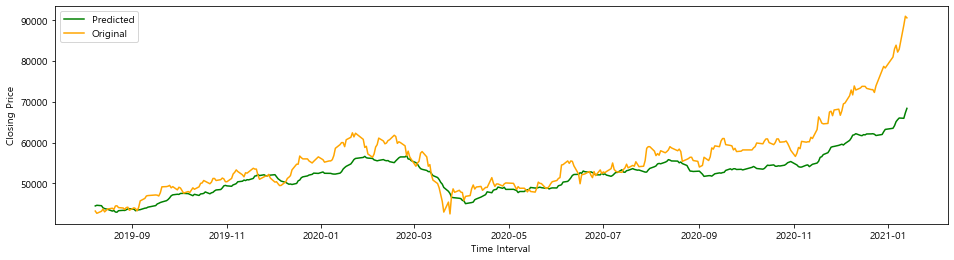

In [1]:
from mod1 import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time 
import math
import seaborn as sb
from sklearn.model_selection import train_test_split


#df=pd.read_csv(input_file)
df = select_stock('삼성전자', '2015-01-01')
np.random.seed(5)
df.head()
df= df.set_index(df['Date'])


### Closing prices of stock

close_price=df.iloc[:,7].values
close_price=close_price.reshape(-1,1)
close_price

### Scaling values between 0 & 1. Machine Learning algorithms work better when features are on relatively similar scale & closer to normal distribution

scaler = MinMaxScaler(feature_range=(0, 1))
close_price = scaler.fit_transform(close_price)

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Reshape into X=t and Y=t+1, timestep 240

train_size = int(len(close_price) * 0.6)
test_size = len(close_price) - train_size
train, test = close_price[0:train_size,:], close_price[train_size:len(close_price),:]
train, test = close_price[0:train_size,:], close_price[train_size:len(close_price),:]
look_back = 240
df2 = df.iloc[train_size+look_back+1:len(close_price)]
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

list(zip(trainX,trainY))

### Reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Building LSTM model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback

model =Sequential([
LSTM(25, input_shape=(1, look_back)),
Dropout(0.1),
Dense(1)
])

model.summary()

### Setting optimizer, loss_fn & accuracy

model.compile(loss='mse', optimizer='adam',metrics=['mse'])

ACCURACY_THRESH=0.90

class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('acc')>=ACCURACY_THRESH:
            print('Desired accuracy reached.....stopping training')
            self.model.stop_training=True

callbacks=myCallback()

model.fit(trainX, trainY, epochs=300,batch_size=240, verbose=1)

### Saving the trained model

from keras.models import load_model
model.save('trained_model.h5')  # creates a HDF5 file 'my_model.h5'

#Load back the trained model
#model = load_model('my_model.h5')

### Predictions & Visualization

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

plt.figure(figsize=(16,4))
plt.plot(df2.index,testPredict,color='g')
plt.plot(df2.index,testY.reshape(-1,1),color='orange')
plt.ylabel('Closing Price')
plt.xlabel('Time Interval')
plt.legend(["Predicted", "Original"], loc ="upper left") 
plt.show()
sb.set()

# 2

from mod1 import *
import plaidml.keras
plaidml.keras.install_backend()

name = '세화아이엠씨'
front =200
back =201

start = time.time()  # 시작 시간 저장
df = select_stock(name,'2015-01-01')
df = df.set_index(df['Date'])
df1 = df.iloc[:back]
df1 = df1.set_index(df1['Date'])
df2 = df.iloc[back:]
df2= df2.set_index(df2['Date'])

training_set=df1.iloc[:,3:4].values
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler()
training_set=sc.fit_transform(training_set)

X_train= training_set[0:front]
y_train= training_set[1:back]

X_train=np.reshape(X_train, (front , 1 , 1))

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

regressor = Sequential()
regressor.add(LSTM(units=18, return_sequences=True, activation= 'relu',input_shape=( 1,1)))
regressor.add(LSTM(units=4))
regressor.add(Dense( units=1 ))
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, y_train, batch_size=32, epochs=300)

real_stock_price = df2.iloc[:,3:4].values

inputs = real_stock_price
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (df2.shape[0] , 1, 1))
predicted_stock_price = regressor.predict(inputs)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


plt.plot(df2.index,real_stock_price , color = 'red' , label = 'Real Stock Price')
plt.plot(df2.index,predicted_stock_price , color = 'blue' , label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel( 'time' )
plt.ylabel( name+'Stock Price' )
plt.legend()
plt.show()
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간